In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib.pyplot import figure
import itertools
import random


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function Definitions

In [157]:
def active_reproducibility(manual_seed=42):
    """
      Function that set random seeds for every used library.
    """

    torch.manual_seed(manual_seed)
    random.seed(manual_seed)
    np.random.seed(manual_seed)


def evaluate(model, X_valid, y_valid, loss_fn, **model_args):
    """
      Evaluate trained model over (X_valid, y_valid) dataset throught loss_fn.
    """

    model.eval()
    
    with torch.no_grad():
        y_pred = model(X_valid, **model_args)

        if type(y_pred) == tuple:
          y_pred = y_pred[0]

        loss = loss_fn(y_pred.view(-1), y_valid.view(-1))
        
    return loss.item()


def train(X_train, y_train, X_valid, y_valid, model_compile, one_step_train, train_args):
    learning_rate = train_args["learning_rate"]
    num_epochs = train_args["num_epochs"]

    model_args = train_args.copy()
    del model_args["learning_rate"]
    del model_args["num_epochs"]


    X_train = X_train.to(DEVICE)
    y_train = y_train.to(DEVICE)
    
    X_valid = X_valid.to(DEVICE)
    y_valid = y_valid.to(DEVICE)

    model = model_compile(model_args).to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    loss_fn = torch.nn.MSELoss(reduction="mean")

    train_losses = []
    valid_losses = []
    

    for i in tqdm(range(num_epochs)):
        model.train()

        # one step train
        train_loss, valid_loss = one_step_train(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn)

        train_losses.append(train_loss)
    
        valid_losses.append(valid_loss)
    
    return train_losses, valid_losses, model


def grid_search(model_compile, one_step_train_loop, grid, X_train, y_train, X_valid, y_valid):
    
    best_loss = np.inf
    best_params = None
    best_train_losses = None
    best_valid_losses = None
    
    for args_comb in itertools.product(*grid.values()):

        train_args = {k:v for (k, v) in zip(list(grid.keys()), args_comb)}
        
        train_losses, valid_losses, _ = train(X_train, y_train, X_valid, y_valid, model_compile, one_step_train_loop, train_args)
        
        if valid_losses[-1] < best_loss:
            best_loss = valid_losses[-1]
            best_params = train_args
            best_train_losses = train_losses
            best_valid_losses = valid_losses

        print(" -- finished", train_args, "loss", valid_losses[-1])
            
    print("finished grid search, the best are:", best_params, "with a loss of: ", best_loss)
        
    return best_train_losses, best_valid_losses, best_params


def predict(X, model):
    return model(X.to(DEVICE))

## Time Delay Neural Network

Here I will define the Time Delay Neural Network model, its compile function and the training step.

In [158]:
import torch.nn.functional as F

class TDNN(nn.Module):
    def __init__(self, window_size=5, hidden_layers=1, hidden_dim=128, out_dim=1):
        super().__init__()
        
        self.window_size = window_size
        
        layers = [nn.Linear(window_size, hidden_dim), nn.ReLU()]
        
        for i in range(hidden_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, out_dim))
        
        self.sequential = nn.Sequential(*layers)
        
    def forward(self, x):
        pad = torch.zeros(self.window_size-1).to(DEVICE)
        input_ = torch.cat([pad, x]).unfold(dimension=0, size=self.window_size, step=1)
        
        return self.sequential(input_)

In [159]:
def model_compile_tdnn(args):
    return TDNN(**args)


def one_step_train_loop_tdnn(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()
    valid_loss = evaluate(model, X_valid, y_valid, loss_fn)

    return train_loss, valid_loss

## RNN

Here I will define the Recurrent Neural Network model, its compile function and the training step.

In [160]:
class RNNModel(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=128, hidden_layers=1, output_dim=1, act_fn='tanh'):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.hidden_layers = hidden_layers
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, hidden_layers, nonlinearity=act_fn)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, h0=None):
        if h0 is None:
          hidden_state = torch.zeros(self.hidden_layers, self.hidden_dim).to(DEVICE)

        if len(x.shape) == 1:
          x = x.reshape((x.shape[0], 1))

        out, hn = self.rnn(x, h0)
        
        out = self.fc(out)
        return out, hn

In [161]:
def model_compile_rnn(args):
    return RNNModel(**args)


def one_step_train_loop_rnn(X_train, y_train, X_valid, y_valid, model, optimizer, loss_fn):
    optimizer.zero_grad()
    y_pred, hidden_state = model(X_train)

    loss = loss_fn(y_pred.view(-1), y_train.view(-1))
    loss.backward()
    optimizer.step()
    hidden_state = hidden_state.detach()

    train_loss = loss.item()

    valid_loss = evaluate(model, X_valid, y_valid, loss_fn, **{"h0" : hidden_state})

    return train_loss, valid_loss

# NARMA10

The first Task is concerned to the prediction of NARMA10 dataset.
Here I will load the dataset from the csv file, splitting it into input (X) and output (y) and I will plot the first 200 elements of each of them.

In [162]:
data_narma10 = pd.read_csv("NARMA10.csv", header=None)

In [163]:
data_narma10.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.083964,0.48934,0.35635,0.25024,0.23554,0.029809,0.34099,0.021216,0.035723,0.26082,...,0.08209,0.19951,0.26618,0.43761,0.32952,0.39381,0.063013,0.26249,0.44974,0.054542
1,0.000000,0.00000,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,...,0.26495,0.21299,0.26849,0.19633,0.32609,0.31816,0.448240,0.26351,0.20217,0.365350


In [164]:
X = torch.Tensor(data_narma10.values[0, :])
y = torch.Tensor(data_narma10.values[1, :])

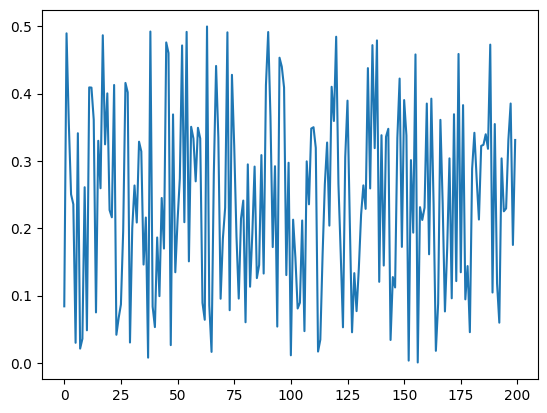

In [165]:
plt.plot(X[:200])
plt.show()

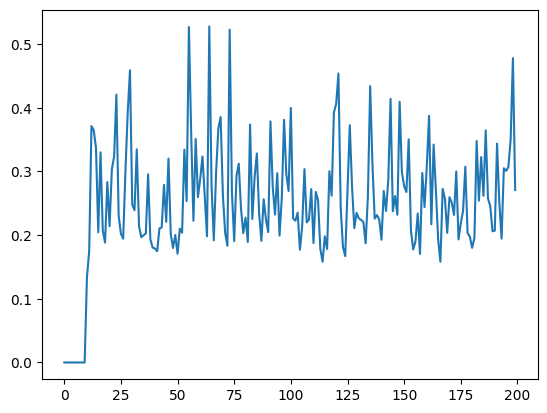

In [166]:
plt.plot(y[:200])
plt.show()

## TDNN

In [167]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

Grid search for Time Delay Neural Network over NARMA10 dataset.
I will search over:
- number of delay's steps (window_size).
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [168]:
grid = {
    "window_size" : [10, 30],
    "hidden_layers" : [1, 2],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-3, 1e-2],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_tdnn, one_step_train_loop_tdnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:00<00:00, 572.00it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004536977969110012


100%|██████████| 200/200 [00:00<00:00, 583.10it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004992878995835781


100%|██████████| 200/200 [00:00<00:00, 588.22it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004556445870548487


100%|██████████| 200/200 [00:00<00:00, 578.50it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004923556465655565


100%|██████████| 200/200 [00:00<00:00, 485.42it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.004780975170433521


100%|██████████| 200/200 [00:00<00:00, 479.72it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00498260697349906


100%|██████████| 200/200 [00:00<00:00, 437.34it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0047223446890711784


100%|██████████| 200/200 [00:00<00:00, 477.44it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.004982487764209509


100%|██████████| 200/200 [00:00<00:00, 562.48it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.001038514543324709


100%|██████████| 200/200 [00:00<00:00, 583.51it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.001201946404762566


100%|██████████| 200/200 [00:00<00:00, 585.27it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0009183281217701733


100%|██████████| 200/200 [00:00<00:00, 551.99it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0009206707472912967


100%|██████████| 200/200 [00:00<00:00, 460.86it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0007271080976352096


100%|██████████| 200/200 [00:00<00:00, 464.53it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.00045657975715585053


100%|██████████| 200/200 [00:00<00:00, 381.00it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0008539968985132873


100%|██████████| 200/200 [00:00<00:00, 367.80it/s]

 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.01, 'num_epochs': 200} loss 0.0006910305237397552
finished grid search, the best are: {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 200} with a loss of:  0.00045657975715585053


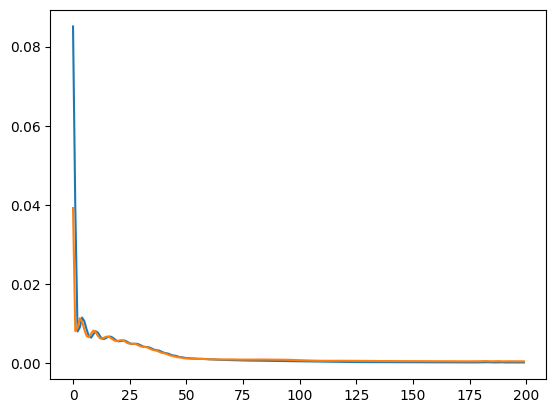

In [169]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [170]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [171]:
best_params

{'window_size': 30,
 'hidden_layers': 2,
 'hidden_dim': 128,
 'learning_rate': 0.01,
 'num_epochs': 200}

In [172]:
train_losses, test_losses, model = train(X_train, y_train, X_test, y_test, model_compile_tdnn, one_step_train_loop_tdnn, best_params)

100%|██████████| 200/200 [00:00<00:00, 375.98it/s]


In [173]:
print(train_losses[-1])
print(test_losses[-1])

0.00015150663966778666
0.00025124484091065824


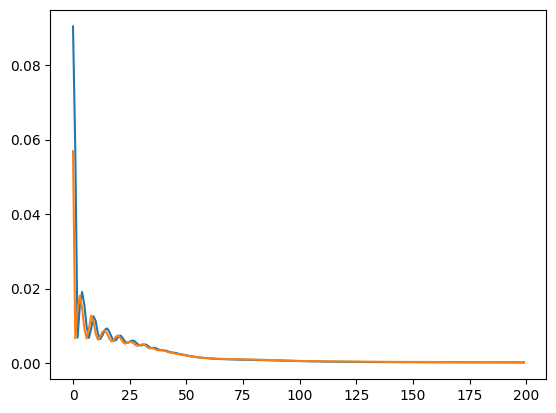

In [174]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

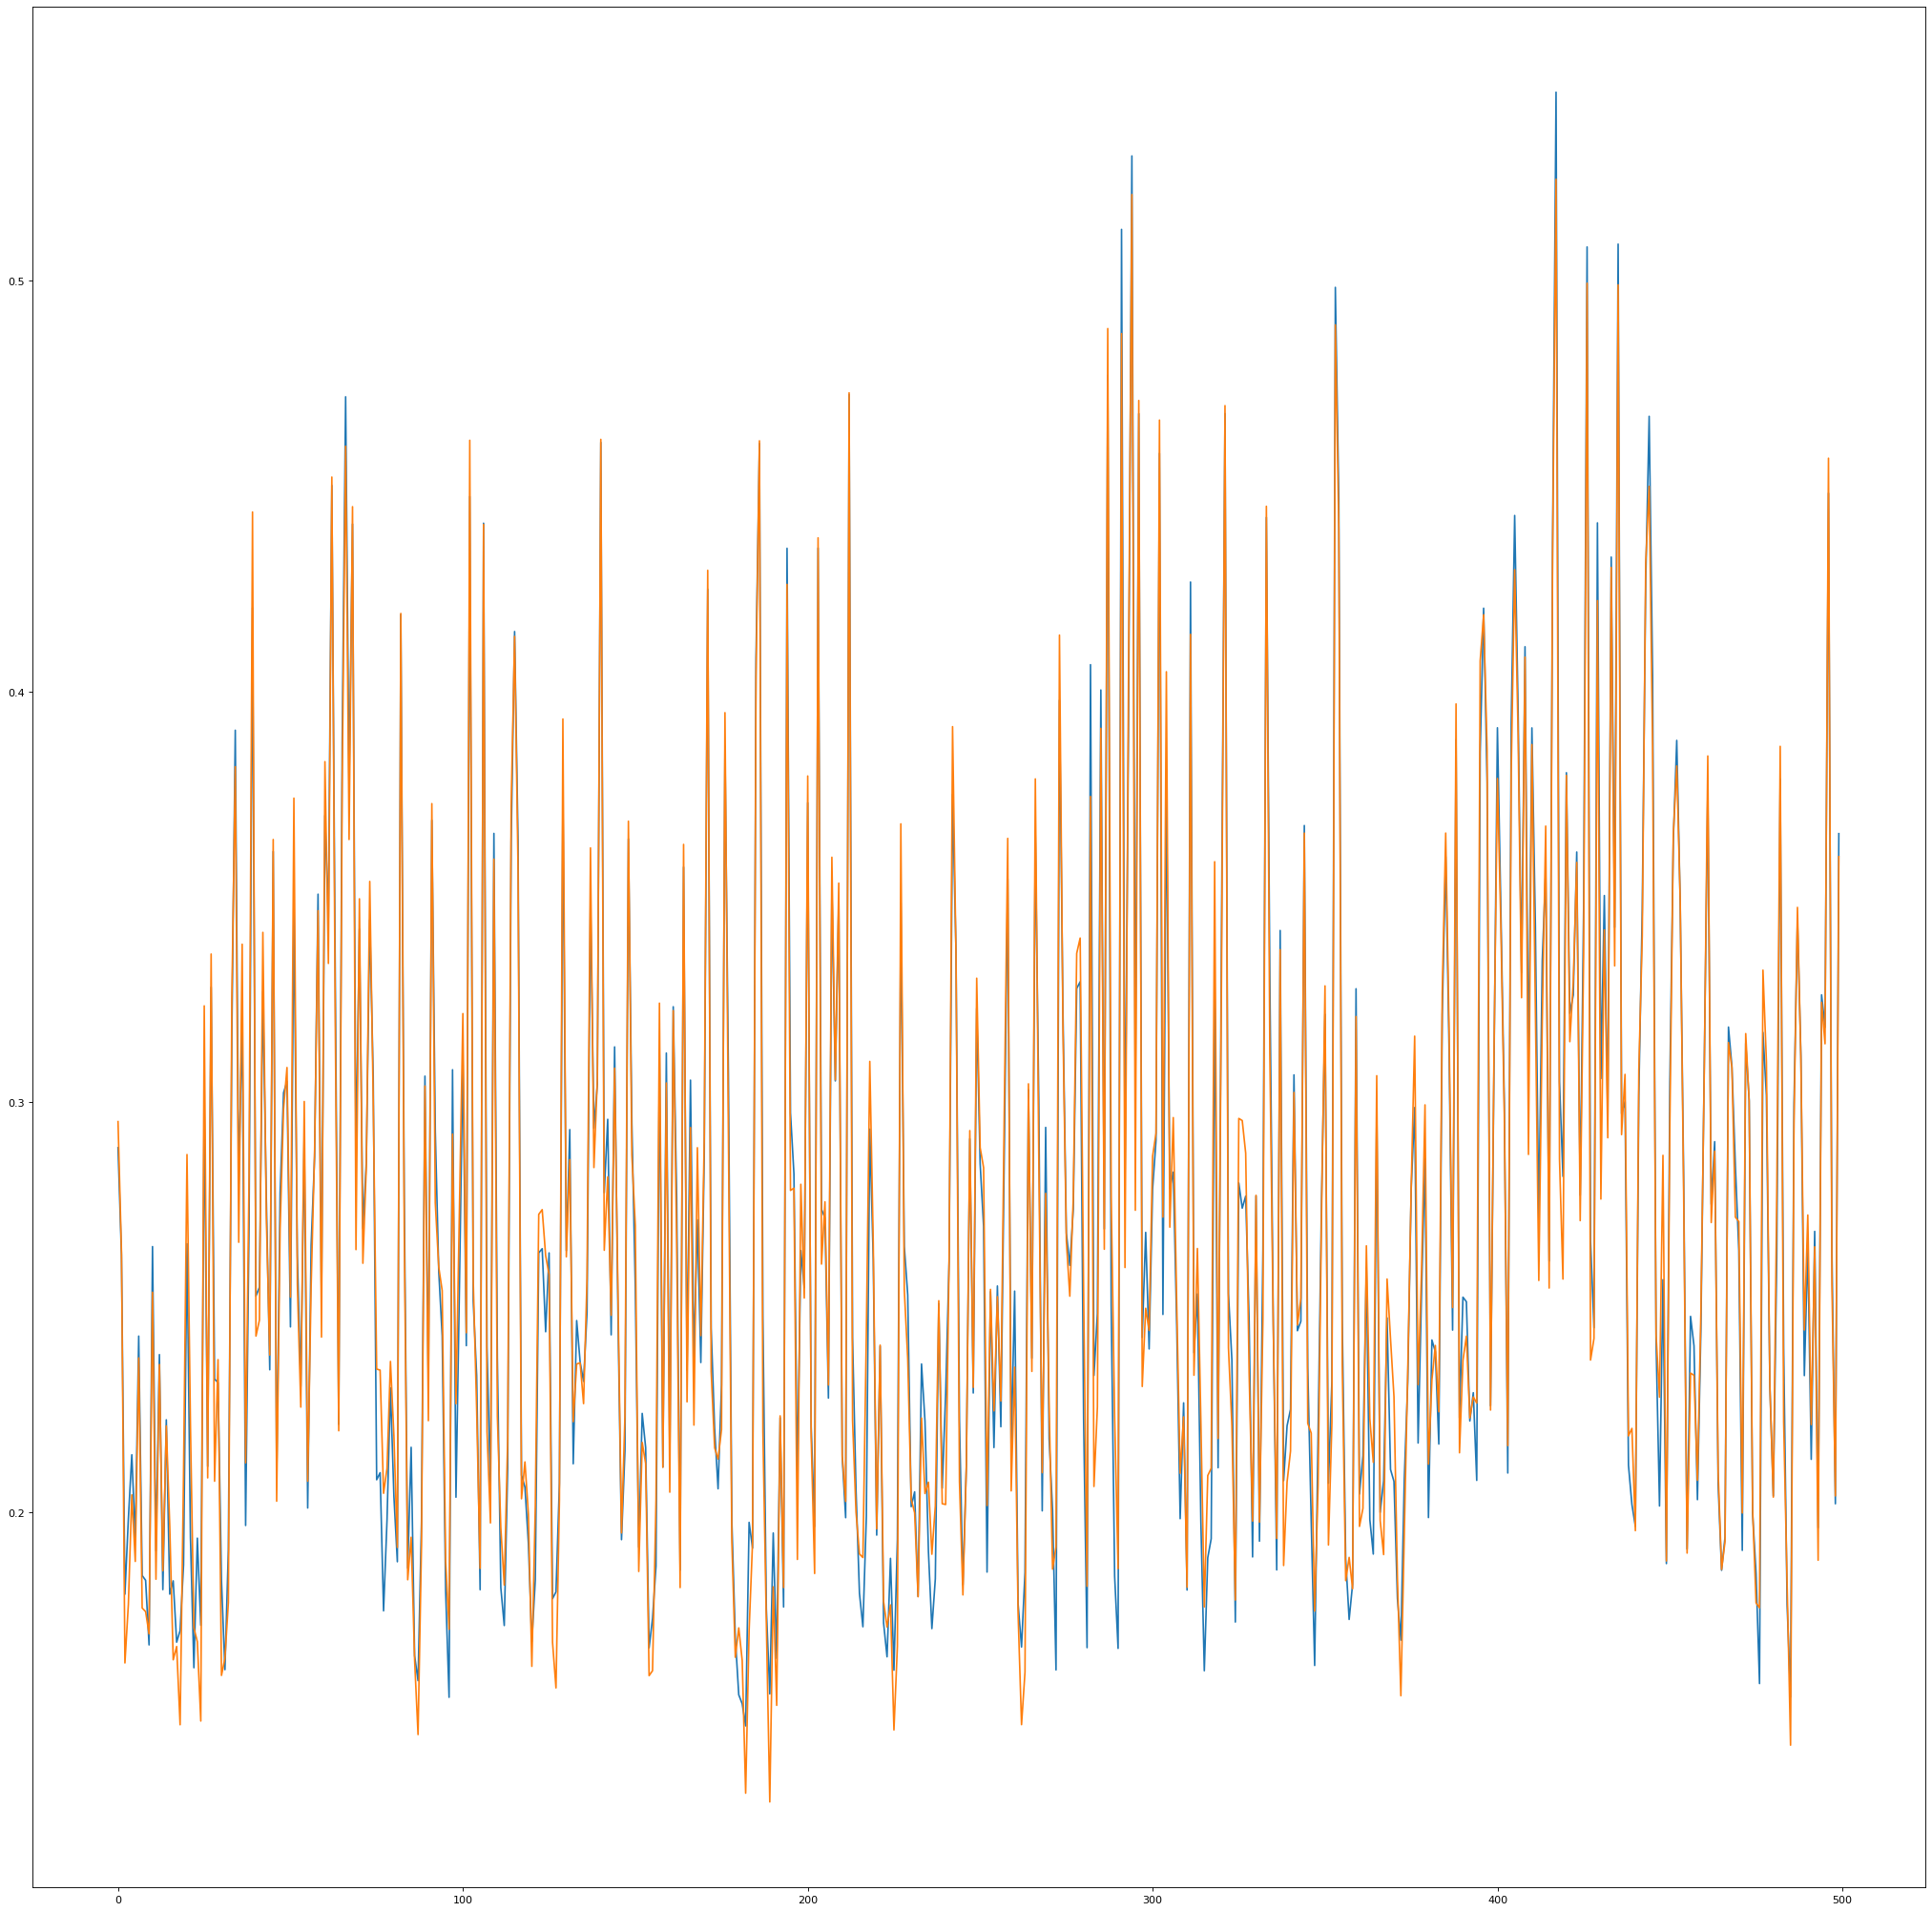

In [175]:
figure(figsize=(32, 32), dpi=80)
y_pred = predict(torch.Tensor(X), model)
plt.plot(y[-500:])
plt.plot(y_pred[-500:].view(-1).detach().to("cpu"))
plt.show()

## RNN

In [176]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

Grid search for Recurrent Neural Network over NARMA10 dataset.
I will search over:
- number of hidden layers (hidden_layers).
- dimensionality of the hidden layers (hidden_dim).
- learning rate.
- number of epochs

In [177]:
grid = {
    "hidden_layers" : [1, 2, 4],
    "hidden_dim" : [128, 256],
    "learning_rate" : [1e-3, 1e-4],
    "num_epochs" : [200]
}

train_losses, valid_losses, best_params = grid_search(model_compile_rnn, one_step_train_loop_rnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 200/200 [00:02<00:00, 73.17it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0024989068042486906


100%|██████████| 200/200 [00:02<00:00, 76.70it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.006548289675265551


100%|██████████| 200/200 [00:06<00:00, 32.49it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.002409092616289854


100%|██████████| 200/200 [00:06<00:00, 33.12it/s]


 -- finished {'hidden_layers': 1, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0047135488130152225


100%|██████████| 200/200 [00:03<00:00, 63.12it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.001236788579262793


100%|██████████| 200/200 [00:03<00:00, 51.06it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.006223054137080908


100%|██████████| 200/200 [00:11<00:00, 17.64it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.002209767932072282


100%|██████████| 200/200 [00:11<00:00, 17.52it/s]


 -- finished {'hidden_layers': 2, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.004000998567789793


100%|██████████| 200/200 [00:05<00:00, 34.64it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.0019023959757760167


100%|██████████| 200/200 [00:05<00:00, 35.49it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 128, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.005524074658751488


100%|██████████| 200/200 [00:22<00:00,  9.02it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 200} loss 0.001941200578585267


100%|██████████| 200/200 [00:22<00:00,  8.99it/s]

 -- finished {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.0001, 'num_epochs': 200} loss 0.0018552177352830768
finished grid search, the best are: {'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 200} with a loss of:  0.001236788579262793


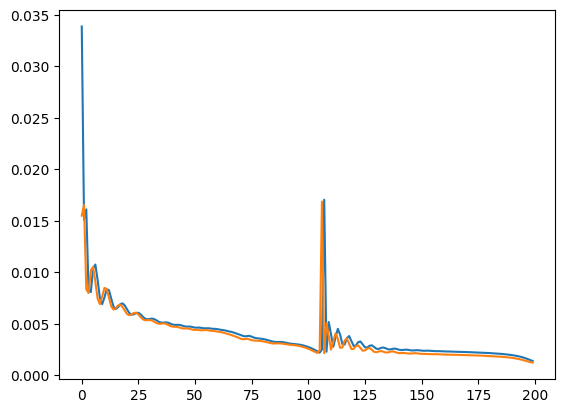

In [178]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [179]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [180]:
best_params

{'hidden_layers': 2,
 'hidden_dim': 128,
 'learning_rate': 0.001,
 'num_epochs': 200}

In [181]:
train_losses, valid_losses, model = train(X_train, y_train, X_test, y_test, model_compile_rnn, one_step_train_loop_rnn, best_params)

100%|██████████| 200/200 [00:05<00:00, 35.98it/s]


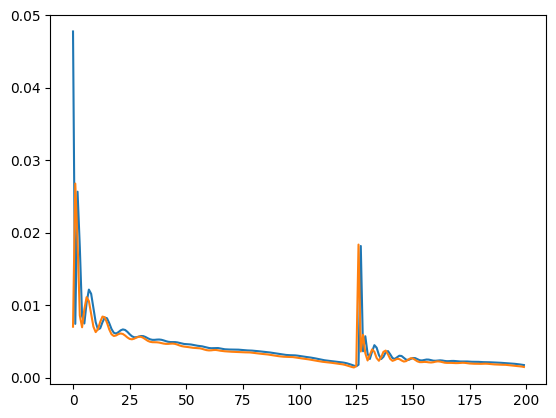

In [182]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [183]:
print(train_losses[-1])
print(valid_losses[-1])

0.0017280835891142488
0.001462318585254252


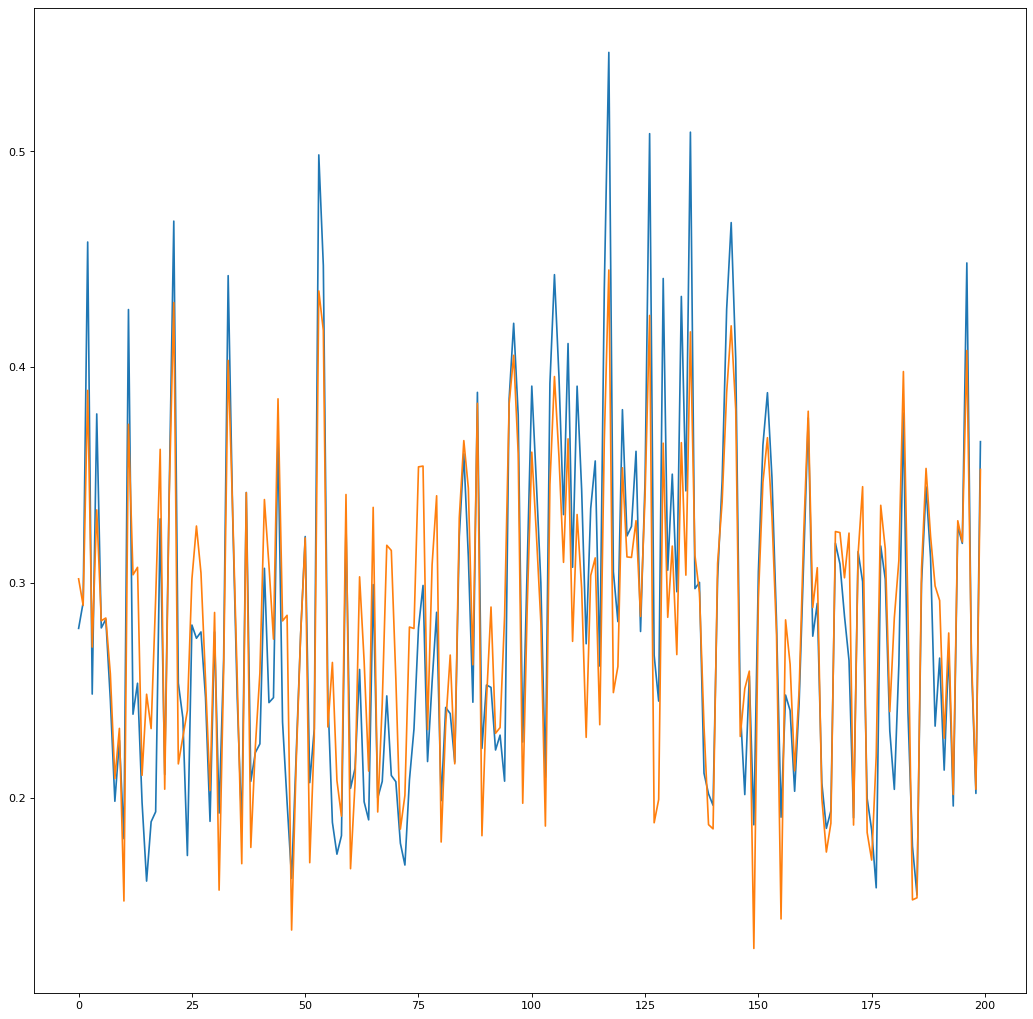

In [184]:
figure(figsize=(16, 16), dpi=80)
y_pred, _ = predict(torch.Tensor(X), model)
plt.plot(y[-200:])
plt.plot(y_pred[-200:].view(-1).detach().to("cpu"))
plt.show()

# MG17

In [185]:
data_mg17 = pd.read_csv("MG17.csv", header=None)

In [186]:
data_mg17.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,0.032164,0.040426,0.057861,0.084015,0.11544,0.14572,0.16758,0.17624,0.17107,0.15465,...,-0.43905,-0.43957,-0.42772,-0.40213,-0.36305,-0.31286,-0.25555,-0.19556,-0.1368,-0.082192


In [187]:
data = data_narma10.values[0, :]

X = torch.Tensor(data[:-1])
y = torch.Tensor(data[1:])

In [188]:
X

tensor([0.0840, 0.4893, 0.3564,  ..., 0.0630, 0.2625, 0.4497])

In [189]:
y

tensor([0.4893, 0.3564, 0.2502,  ..., 0.2625, 0.4497, 0.0545])

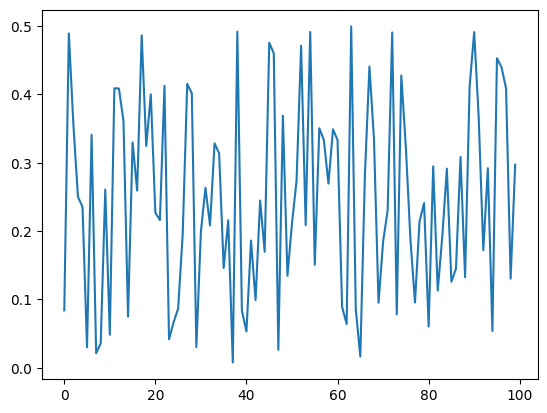

In [190]:
plt.plot(X[:100])
plt.show()

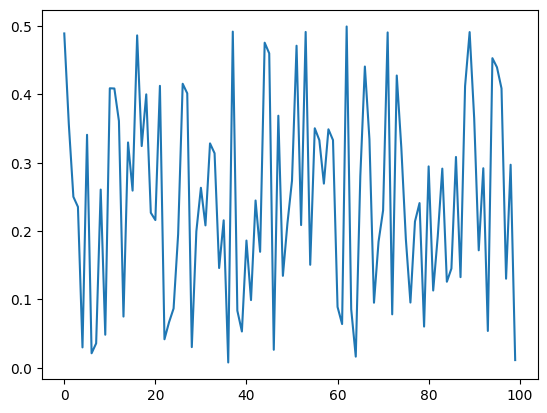

In [191]:
plt.plot(y[:100])
plt.show()

## TDNN

In [210]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [215]:
grid = {
    "window_size" : [5, 10, 20, 30],
    "hidden_layers" : [1, 2, 5, 10, 20],
    "hidden_dim" : [128],
    "learning_rate" : [1e-3, 1e-2, 1e-1],
    "num_epochs" : [100]
}

train_losses, valid_losses, best_params = grid_search(model_compile_tdnn, one_step_train_loop_tdnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 100/100 [00:00<00:00, 242.69it/s]


 -- finished {'window_size': 5, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.021119633689522743


100%|██████████| 100/100 [00:00<00:00, 335.33it/s]


 -- finished {'window_size': 5, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.021024135872721672


100%|██████████| 100/100 [00:00<00:00, 280.28it/s]


 -- finished {'window_size': 5, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.02101011388003826


100%|██████████| 100/100 [00:00<00:00, 279.23it/s]


 -- finished {'window_size': 5, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.02105395682156086


100%|██████████| 100/100 [00:00<00:00, 383.13it/s]


 -- finished {'window_size': 5, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.02095814421772957


100%|██████████| 100/100 [00:00<00:00, 383.22it/s]


 -- finished {'window_size': 5, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.020993996411561966


100%|██████████| 100/100 [00:00<00:00, 265.12it/s]


 -- finished {'window_size': 5, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.020991843193769455


100%|██████████| 100/100 [00:00<00:00, 253.41it/s]


 -- finished {'window_size': 5, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.02107367478311062


100%|██████████| 100/100 [00:00<00:00, 255.26it/s]


 -- finished {'window_size': 5, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.02099842205643654


100%|██████████| 100/100 [00:00<00:00, 164.19it/s]


 -- finished {'window_size': 5, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.02098684385418892


100%|██████████| 100/100 [00:00<00:00, 200.43it/s]


 -- finished {'window_size': 5, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.02103026770055294


100%|██████████| 100/100 [00:00<00:00, 226.41it/s]


 -- finished {'window_size': 5, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.9392552971839905


100%|██████████| 100/100 [00:00<00:00, 143.55it/s]


 -- finished {'window_size': 5, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.020985187962651253


100%|██████████| 100/100 [00:00<00:00, 138.28it/s]


 -- finished {'window_size': 5, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.020987937226891518


100%|██████████| 100/100 [00:00<00:00, 140.21it/s]


 -- finished {'window_size': 5, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 2565.644775390625


100%|██████████| 100/100 [00:00<00:00, 588.95it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.021072741597890854


100%|██████████| 100/100 [00:00<00:00, 590.29it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.020992528647184372


100%|██████████| 100/100 [00:00<00:00, 588.86it/s]


 -- finished {'window_size': 10, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.020986631512641907


100%|██████████| 100/100 [00:00<00:00, 483.46it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.02106153406202793


100%|██████████| 100/100 [00:00<00:00, 484.40it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.020948197692632675


100%|██████████| 100/100 [00:00<00:00, 505.45it/s]


 -- finished {'window_size': 10, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.02099933847784996


100%|██████████| 100/100 [00:00<00:00, 344.61it/s]


 -- finished {'window_size': 10, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.021087951958179474


100%|██████████| 100/100 [00:00<00:00, 328.28it/s]


 -- finished {'window_size': 10, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.02094266377389431


100%|██████████| 100/100 [00:00<00:00, 322.86it/s]


 -- finished {'window_size': 10, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.020992925390601158


100%|██████████| 100/100 [00:00<00:00, 235.26it/s]


 -- finished {'window_size': 10, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.020990479737520218


100%|██████████| 100/100 [00:00<00:00, 230.34it/s]


 -- finished {'window_size': 10, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.020990949124097824


100%|██████████| 100/100 [00:00<00:00, 240.53it/s]


 -- finished {'window_size': 10, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.1150781586766243


100%|██████████| 100/100 [00:00<00:00, 147.08it/s]


 -- finished {'window_size': 10, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.020988119766116142


100%|██████████| 100/100 [00:00<00:00, 142.86it/s]


 -- finished {'window_size': 10, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.02098897658288479


100%|██████████| 100/100 [00:00<00:00, 135.75it/s]


 -- finished {'window_size': 10, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 93.04456329345703


100%|██████████| 100/100 [00:00<00:00, 566.26it/s]


 -- finished {'window_size': 20, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.021752072498202324


100%|██████████| 100/100 [00:00<00:00, 497.89it/s]


 -- finished {'window_size': 20, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.021529866382479668


100%|██████████| 100/100 [00:00<00:00, 551.21it/s]


 -- finished {'window_size': 20, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.02099517546594143


100%|██████████| 100/100 [00:00<00:00, 464.41it/s]


 -- finished {'window_size': 20, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.021659914404153824


100%|██████████| 100/100 [00:00<00:00, 483.31it/s]


 -- finished {'window_size': 20, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.021105164662003517


100%|██████████| 100/100 [00:00<00:00, 451.75it/s]


 -- finished {'window_size': 20, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.022806666791439056


100%|██████████| 100/100 [00:00<00:00, 284.58it/s]


 -- finished {'window_size': 20, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.0210860688239336


100%|██████████| 100/100 [00:00<00:00, 249.18it/s]


 -- finished {'window_size': 20, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.020986685529351234


100%|██████████| 100/100 [00:00<00:00, 254.19it/s]


 -- finished {'window_size': 20, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.021051129326224327


100%|██████████| 100/100 [00:00<00:00, 167.00it/s]


 -- finished {'window_size': 20, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.020985756069421768


100%|██████████| 100/100 [00:00<00:00, 163.23it/s]


 -- finished {'window_size': 20, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.021152149885892868


100%|██████████| 100/100 [00:00<00:00, 208.55it/s]


 -- finished {'window_size': 20, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 1.4872990846633911


100%|██████████| 100/100 [00:00<00:00, 139.72it/s]


 -- finished {'window_size': 20, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.020985808223485947


100%|██████████| 100/100 [00:00<00:00, 142.79it/s]


 -- finished {'window_size': 20, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.02098795399069786


100%|██████████| 100/100 [00:00<00:00, 143.76it/s]


 -- finished {'window_size': 20, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 9.300518035888672


100%|██████████| 100/100 [00:00<00:00, 558.18it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.021805539727211


100%|██████████| 100/100 [00:00<00:00, 581.65it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.021225247532129288


100%|██████████| 100/100 [00:00<00:00, 544.87it/s]


 -- finished {'window_size': 30, 'hidden_layers': 1, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.020985612645745277


100%|██████████| 100/100 [00:00<00:00, 469.66it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.021291067823767662


100%|██████████| 100/100 [00:00<00:00, 464.37it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.02115773595869541


100%|██████████| 100/100 [00:00<00:00, 424.08it/s]


 -- finished {'window_size': 30, 'hidden_layers': 2, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.021007146686315536


100%|██████████| 100/100 [00:00<00:00, 341.02it/s]


 -- finished {'window_size': 30, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.021018609404563904


100%|██████████| 100/100 [00:00<00:00, 333.21it/s]


 -- finished {'window_size': 30, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.021427055820822716


100%|██████████| 100/100 [00:00<00:00, 326.59it/s]


 -- finished {'window_size': 30, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 0.021116288378834724


100%|██████████| 100/100 [00:00<00:00, 225.79it/s]


 -- finished {'window_size': 30, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.020986249670386314


100%|██████████| 100/100 [00:00<00:00, 221.82it/s]


 -- finished {'window_size': 30, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.020986737683415413


100%|██████████| 100/100 [00:00<00:00, 225.98it/s]


 -- finished {'window_size': 30, 'hidden_layers': 10, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 23.795852661132812


100%|██████████| 100/100 [00:00<00:00, 135.59it/s]


 -- finished {'window_size': 30, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 100} loss 0.020985828712582588


100%|██████████| 100/100 [00:00<00:00, 142.21it/s]


 -- finished {'window_size': 30, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} loss 0.02098732255399227


100%|██████████| 100/100 [00:00<00:00, 137.59it/s]

 -- finished {'window_size': 30, 'hidden_layers': 20, 'hidden_dim': 128, 'learning_rate': 0.1, 'num_epochs': 100} loss 163.1578369140625
finished grid search, the best are: {'window_size': 10, 'hidden_layers': 5, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 100} with a loss of:  0.02094266377389431


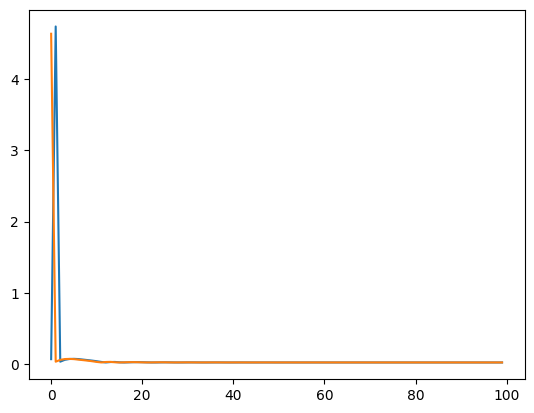

In [194]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [195]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [196]:
best_params

{'window_size': 50,
 'hidden_layers': 5,
 'hidden_dim': 256,
 'learning_rate': 0.01,
 'num_epochs': 100}

In [197]:
train_losses, test_losses, model = train(X_train, y_train, X_test, y_test, model_compile_tdnn, one_step_train_loop_tdnn, best_params)

100%|██████████| 100/100 [00:00<00:00, 217.26it/s]


In [198]:
print(train_losses[-1])
print(test_losses[-1])

0.02058601938188076
0.02082248032093048


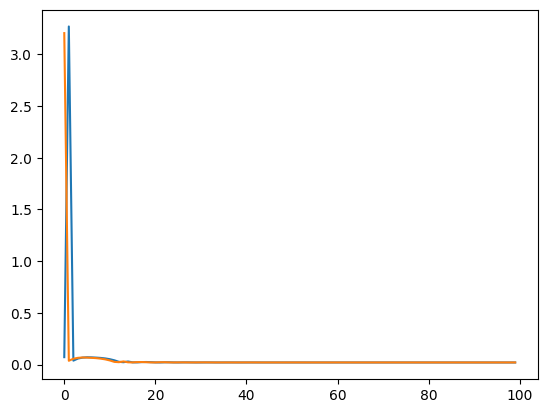

In [199]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

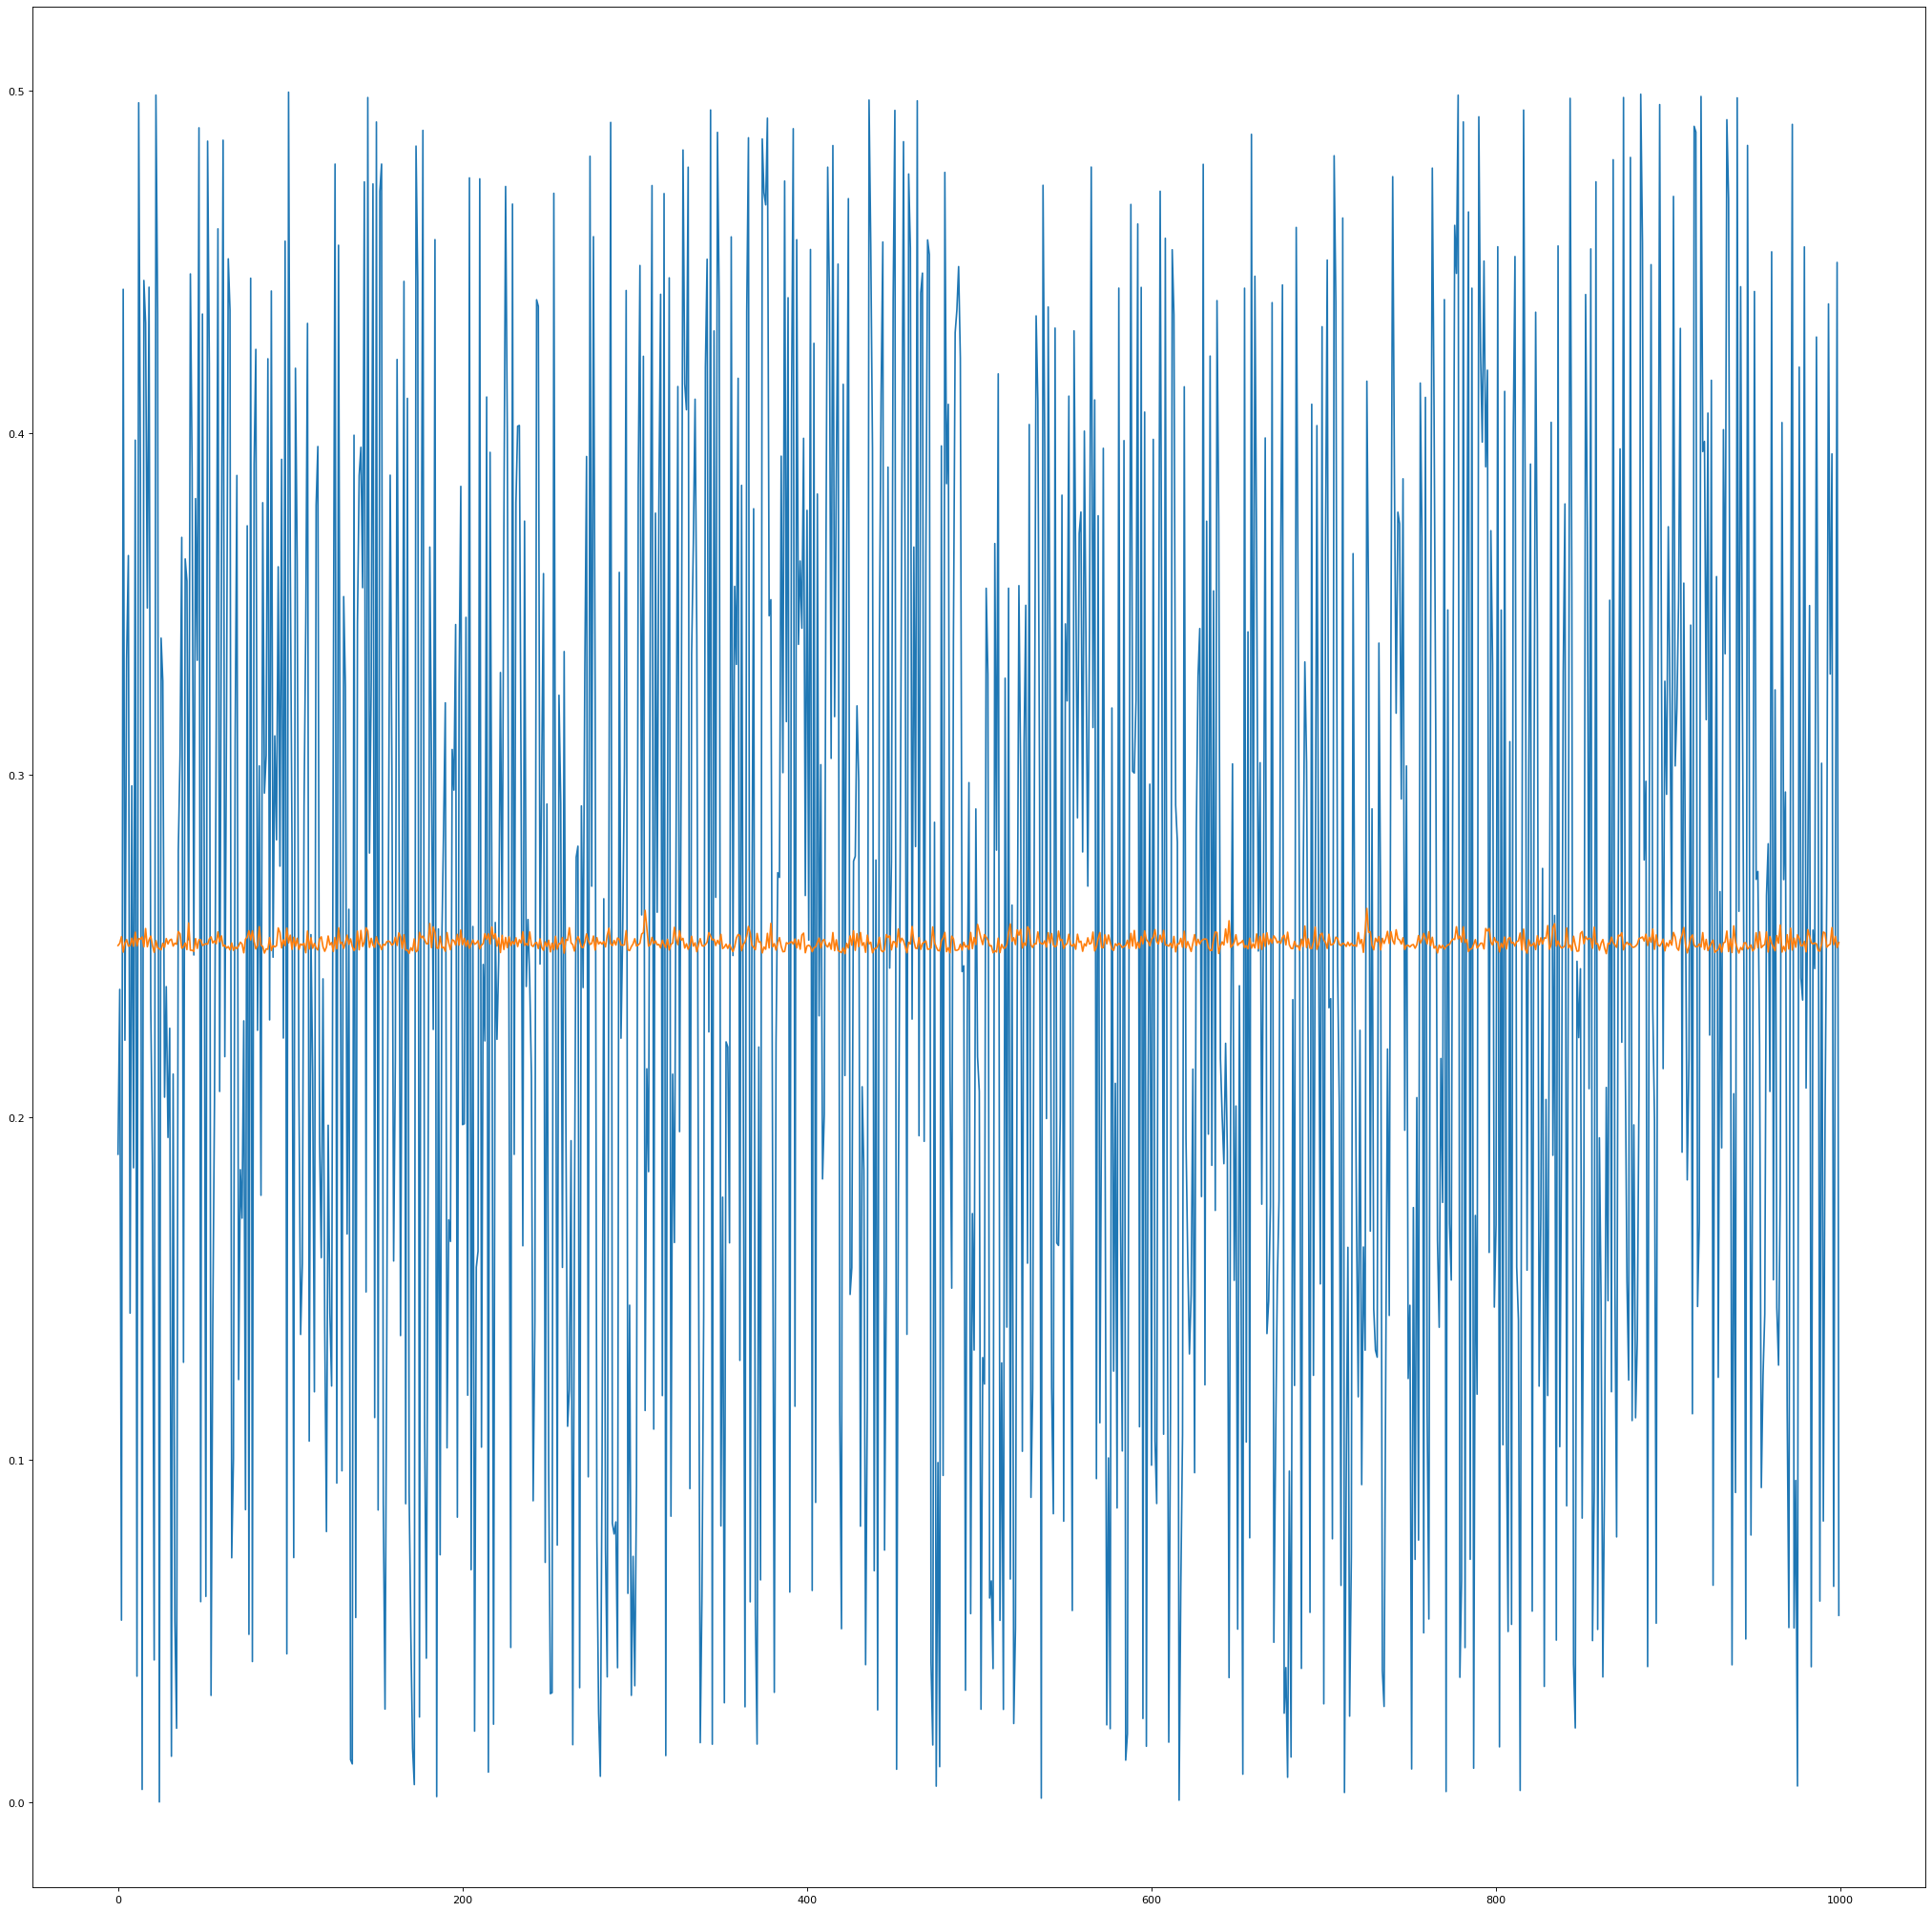

In [200]:
figure(figsize=(32, 32), dpi=80)
y_pred = predict(torch.Tensor(X), model)
plt.plot(y[-1000:])
plt.plot(y_pred[-1000:].view(-1).detach().to("cpu"))
plt.show()

## RNN

In [201]:
# train split
X_train = X[:4000]
y_train = y[:4000]

# valid split
X_valid = X[4000:5000]
y_valid = y[4000:5000]

In [202]:
grid = {
    "hidden_layers" : [4],
    "hidden_dim" : [256, 512],
    "learning_rate" : [1e-3],
    "num_epochs" : [300]
}

train_losses, valid_losses, best_params = grid_search(model_compile_rnn, one_step_train_loop_rnn, grid, X_train, y_train, X_valid, y_valid)

100%|██████████| 300/300 [00:33<00:00,  9.00it/s]


 -- finished {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 300} loss 0.02101481705904007


100%|██████████| 300/300 [01:49<00:00,  2.73it/s]

 -- finished {'hidden_layers': 4, 'hidden_dim': 512, 'learning_rate': 0.001, 'num_epochs': 300} loss 0.021082725375890732
finished grid search, the best are: {'hidden_layers': 4, 'hidden_dim': 256, 'learning_rate': 0.001, 'num_epochs': 300} with a loss of:  0.02101481705904007


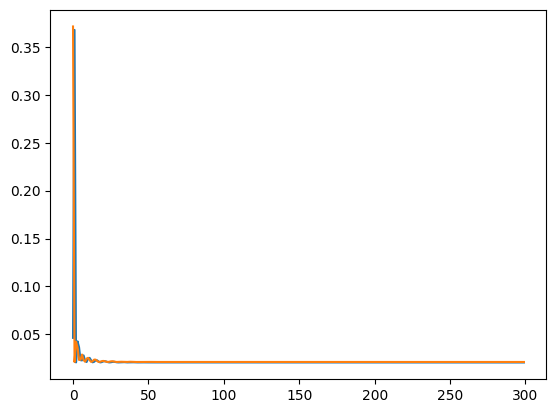

In [203]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [204]:
# test split
X_test = X[5000:]
y_test = y[5000:]

# train split
X_train = X[:5000]
y_train = y[:5000]

In [205]:
train_losses, valid_losses, model = train(X_train, y_train, X_test, y_test, model_compile_rnn, one_step_train_loop_rnn, best_params)

100%|██████████| 300/300 [00:55<00:00,  5.44it/s]


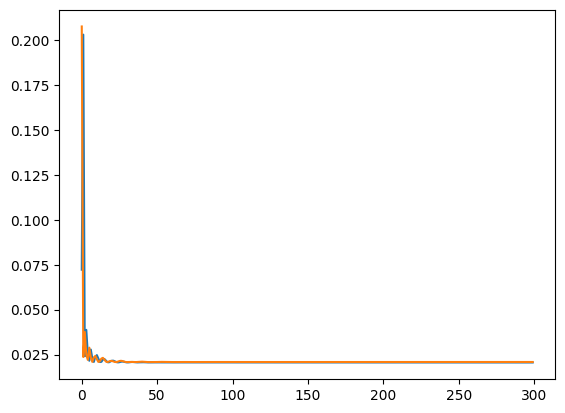

In [206]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()

In [207]:
print(train_losses[-1])
print(valid_losses[-1])

0.020585445687174797
0.020858174189925194


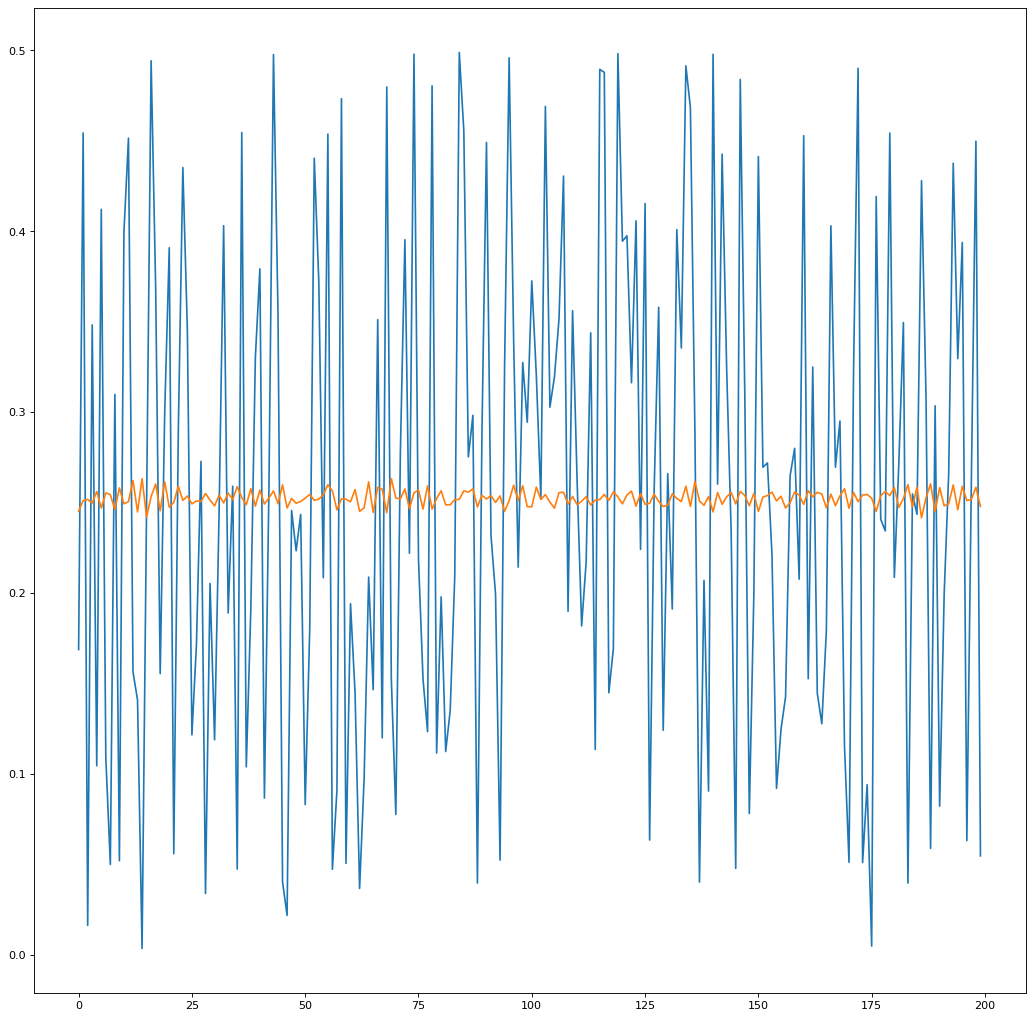

In [208]:
figure(figsize=(16, 16), dpi=80)
y_pred, _ = predict(torch.Tensor(X), model)
plt.plot(y[-200:])
plt.plot(y_pred[-200:].view(-1).detach().to("cpu"))
plt.show()